<a href="https://colab.research.google.com/github/Jyoti200/Sales_forescasting/blob/main/Sale_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Store Sales- Time Series Forecasting

 We will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers.

**train.csv**
1. The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
2. **store_nbr** identifies the store at which the products are sold. **family** identifies the type of product sold.
3. **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
**onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.

**test.csv**
The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
The dates in the test data are for the 15 days after the last date in the training data.

**stores.csv**

Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.

**oil.csv**
Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

**holidays_events.csv**

Holidays and Events, with metadata

To predict sales of a store we need


*   Previous records of sales
*   Holidays present as during holidays sales gets increased
*   Oil prices as Ecuador is an oil based economy
*   Date for time series analysis
*   Geographical location
*   





In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jvyasvy04","key":"9e611d7c9a39585f18c9c56bed196dcf"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv 'kaggle.json' ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c store-sales-time-series-forecasting


 89% 19.0M/21.4M [00:02<00:00, 11.6MB/s]
100% 21.4M/21.4M [00:02<00:00, 9.06MB/s]


In [6]:
!unzip store-sales-time-series-forecasting.zip


Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [7]:
store=pd.read_csv('stores.csv')
store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [8]:
transaction=pd.read_csv('transactions.csv')
transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
holiday=pd.read_csv('holidays_events.csv')
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [10]:
oil=pd.read_csv('oil.csv')
oil.head()


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [11]:
train=pd.read_csv('train.csv')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [12]:
test=pd.read_csv('test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [13]:
def stats(df):
  print("Information of dataset:",df.info())
  print("************")
  print("Shape of dataset:",df.shape)
  print("************")
  print("Statstical Summary:",df.describe())
  print("************")
  print("Null Values:",df.isnull().sum())
  print("************")
  print("Duplicate Values",df.duplicated().sum())

In [14]:
stats(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
Information of dataset: None
************
Shape of dataset: (3000888, 6)
************
Statstical Summary:                  id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.00088

In [15]:
stats(store)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
Information of dataset: None
************
Shape of dataset: (54, 5)
************
Statstical Summary:        store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000
************
Null Values: store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
************
Duplicate Values 0


In [16]:
stats(transaction)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
Information of dataset: None
************
Shape of dataset: (83488, 3)
************
Statstical Summary:           store_nbr  transactions
count  83488.000000  83488.000000
mean      26.939237   1694.602158
std       15.608204    963.286644
min        1.000000      5.000000
25%       13.000000   1046.000000
50%       27.000000   1393.000000
75%       40.000000   2079.000000
max       54.000000   8359.000000
************
Null Values: date            0
store_nbr       0
transactions    0
dtype: int64
************
Duplicate Values 0


In [ ]:
stats(holiday)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
Information of dataset: None
************
Shape of dataset: (350, 6)
************
Statstical Summary:               date     type    locale locale_name description transferred
count          350      350       350         350         350         350
unique         312        6         3          24         103           2
top     2014-06-25  Holiday  National     Ecuador    Carnaval       False
freq             4      221       174         174          10         338
************
Null Values: date           0
typ

In [ ]:
stats(oil)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
Information of dataset: None
************
Shape of dataset: (1218, 2)
************
Statstical Summary:         dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000
************
Null Values: date           0
dcoilwtico    43
dtype: int64
************
Duplicate Values 0


In [ ]:
# dcoilwtico has missing values

In [17]:
# Null values present in oil dataframem
(oil['dcoilwtico'].isna().sum())/len(oil['dcoilwtico'])

0.035303776683087026

In [18]:
# Missing value imputation
oil['dcoilwtico']=oil['dcoilwtico'].fillna(method='bfill').fillna(method='ffill')

In [19]:
(oil['dcoilwtico'].isna().sum())/len(oil['dcoilwtico'])

0.0

In [20]:
train.drop('id',axis=1,inplace=True)

In [21]:
# Converting all date object data type to date data type
train['date']=pd.to_datetime(train['date'])
test['date']=pd.to_datetime(test['date'])
transaction['date']=pd.to_datetime(transaction['date'])
oil['date']=pd.to_datetime(oil['date'])
holiday['date']=pd.to_datetime(holiday['date'])

In [ ]:
# Checking memory usage of this feature!
train['store_nbr'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3000888 entries, 0 to 3000887
Series name: store_nbr
Non-Null Count    Dtype
--------------    -----
3000888 non-null  int64
dtypes: int64(1)
memory usage: 22.9 MB


In [22]:
# The feature is taking alot of memory so we will convert it to int8
train['store_nbr']=train['store_nbr'].astype('int8')
test['store_nbr']=test['store_nbr'].astype('int8')

In [ ]:
train['store_nbr'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3000888 entries, 0 to 3000887
Series name: store_nbr
Non-Null Count    Dtype
--------------    -----
3000888 non-null  int8 
dtypes: int8(1)
memory usage: 2.9 MB


In [23]:
train['sales']=train['sales'].astype('float32')

In [ ]:
train['onpromotion'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3000888 entries, 0 to 3000887
Series name: onpromotion
Non-Null Count    Dtype
--------------    -----
3000888 non-null  int64
dtypes: int64(1)
memory usage: 22.9 MB


In [24]:
train['onpromotion']=train['onpromotion'].astype('int8')
test['onpromotion']=test['onpromotion'].astype('int8')

In [25]:
transaction['store_nbr']=transaction['store_nbr'].astype('int8')

In [ ]:
fig = px.line(transaction, x='date', y='transactions', title='Transactions Over Time')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Transactions'
)

fig.show()

In [ ]:
# We can see transactions peak around end of December and in mid of May that means sales are more during holiday time i.e. chirstmas and battle of pinchina day.

In [26]:
holidays_based_transactions = pd.merge(transaction, holiday, on='date',how='right')
holidays_based_transactions.shape

(13980, 8)

In [ ]:
holidays_based_transactions.head()

,date,store_nbr,transactions,type,locale,locale_name,description,transferred
0,2012-03-02,NaN,NaN,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,NaN,NaN,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,NaN,NaN,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,NaN,NaN,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,NaN,NaN,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
fig = px.line(holidays_based_transactions, x='date', y='transactions', title='Transactions Over Time')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Transactions'
)

fig.show()

**Monthly Average Transactions**

In [ ]:
a = transaction.set_index("date").resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year
px.line(a, x='date', y='transactions', color='year',title = "Monthly Average Transactions" )

In [ ]:
train.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [27]:
data=pd.merge(train,store,on='store_nbr',how='left')
data.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [40]:
test=pd.merge(test,store,on='store_nbr',how='left')
test.head()

,id,date,store_nbr,family,onpromotion,day_of_week,city,state,type,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,2,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,2,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,2,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,2,Quito,Pichincha,D,13


In [28]:
data=pd.merge(data,transaction,on=['date','store_nbr'],how='left')
data.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


In [41]:
test=test.merge(transaction,on=['date','store_nbr'],how='left')
test.head()

,id,date,store_nbr,family,onpromotion,day_of_week,city,state,type,cluster,transactions
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2,Quito,Pichincha,D,13,NaN
1,3000889,2017-08-16,1,BABY CARE,0,2,Quito,Pichincha,D,13,NaN
2,3000890,2017-08-16,1,BEAUTY,2,2,Quito,Pichincha,D,13,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,2,Quito,Pichincha,D,13,NaN
4,3000892,2017-08-16,1,BOOKS,0,2,Quito,Pichincha,D,13,NaN


In [29]:
data=pd.merge(data,oil,on='date',how='left')
data.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,93.14
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,93.14
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,93.14
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,93.14
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,93.14


In [42]:
test=test.merge(oil,on='date',how='left')
test.head()

,id,date,store_nbr,family,onpromotion,day_of_week,city,state,type,cluster,transactions,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2,Quito,Pichincha,D,13,NaN,46.8
1,3000889,2017-08-16,1,BABY CARE,0,2,Quito,Pichincha,D,13,NaN,46.8
2,3000890,2017-08-16,1,BEAUTY,2,2,Quito,Pichincha,D,13,NaN,46.8
3,3000891,2017-08-16,1,BEVERAGES,20,2,Quito,Pichincha,D,13,NaN,46.8
4,3000892,2017-08-16,1,BOOKS,0,2,Quito,Pichincha,D,13,NaN,46.8


In [30]:
data=pd.merge(data,holiday,on='date',how='left')
data.head()

,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False


In [43]:
test=test.merge(holiday,on='date',how='left')
test.head()

,id,date,store_nbr,family,onpromotion,day_of_week,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2,Quito,Pichincha,D,13,NaN,46.8,NaN,NaN,NaN,NaN,NaN
1,3000889,2017-08-16,1,BABY CARE,0,2,Quito,Pichincha,D,13,NaN,46.8,NaN,NaN,NaN,NaN,NaN
2,3000890,2017-08-16,1,BEAUTY,2,2,Quito,Pichincha,D,13,NaN,46.8,NaN,NaN,NaN,NaN,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,2,Quito,Pichincha,D,13,NaN,46.8,NaN,NaN,NaN,NaN,NaN
4,3000892,2017-08-16,1,BOOKS,0,2,Quito,Pichincha,D,13,NaN,46.8,NaN,NaN,NaN,NaN,NaN


In [31]:
final_data=data.copy()

In [32]:
final_data.head()

,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,93.14,Holiday,National,Ecuador,Primer dia del ano,False


# **Exploratory Data Analysis**

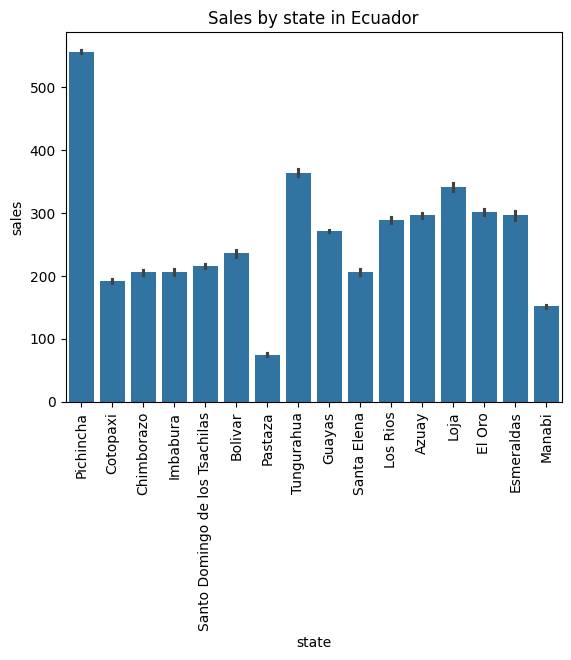

In [ ]:
sns.barplot(x='state',y='sales',data=final_data)
plt.title('Sales by state in Ecuador')
plt.xticks(rotation=90)
plt.show()

**Highest** sales are recorded in *Pichincha* state of Ecuador and lowest sales are of *Pastaza* state.

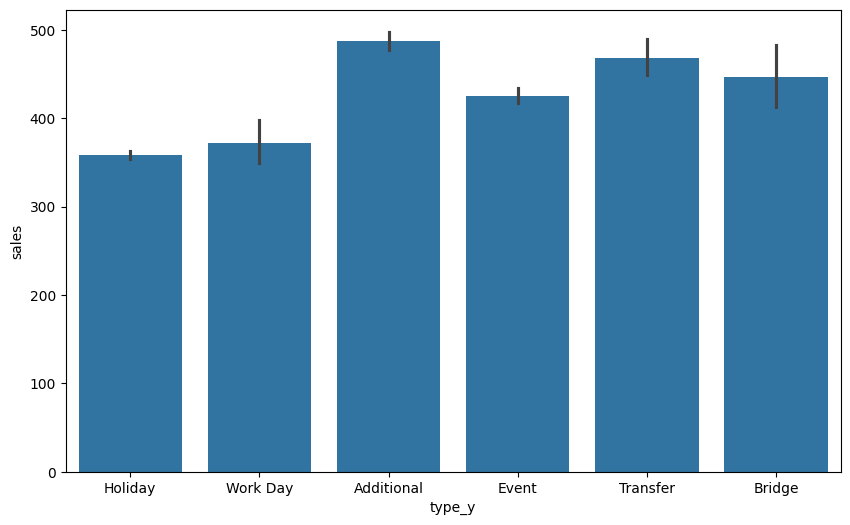

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='type_y', y='sales', data=final_data)
plt.show()

**Highest sales** are observed on *Additional* type of Holidays and second highest is on the days when holidays were *transferred*.

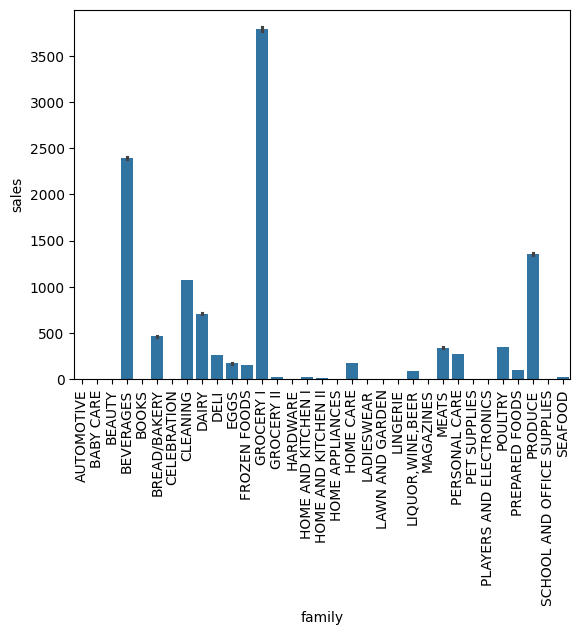

In [ ]:
sns.barplot(x='family',y='sales',data=final_data)
plt.xticks(rotation=90)
plt.show()

**Top** **3** sales are Grocery 1, Beverages and Produce.

In [ ]:
o = oil.set_index("date").resample("M").dcoilwtico.mean().reset_index()
o["year"] = o.date.dt.year
px.line(o, x='date', y='dcoilwtico', color='year',title = "Monthly Average oil production" )

**Oil** Prices after June 30th 2014 are continuously **decreasing**.

It is due to protestes conducted by Enviornmentalist and in 2024 voters voted against oil drilling in Amazon Forest.

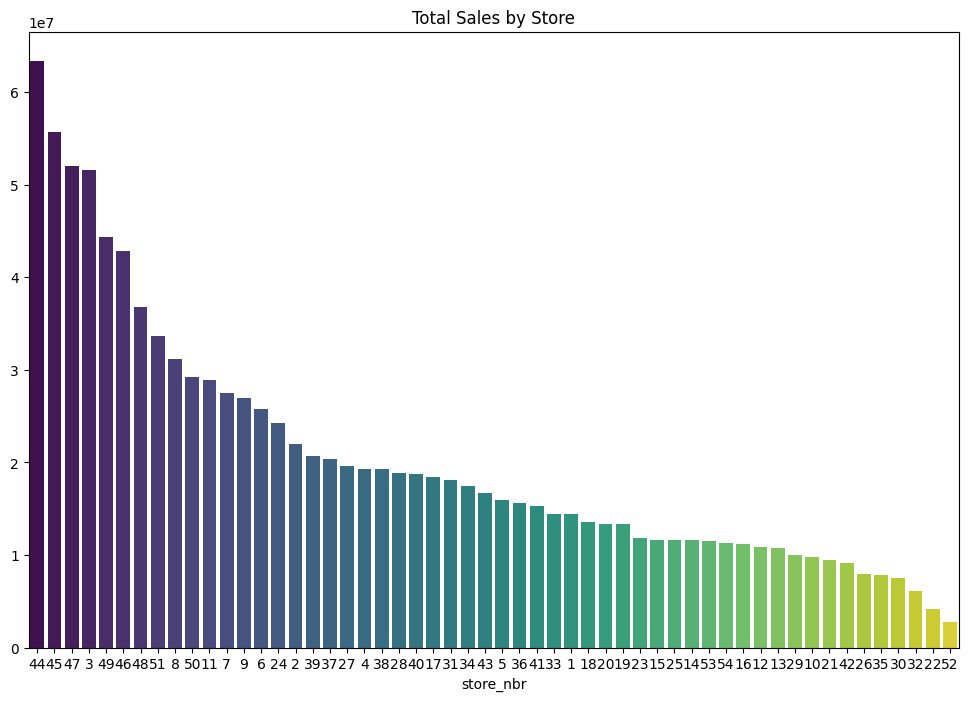

In [ ]:
# Which store is having highest sales?
sal=final_data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=sal.index, y=sal.values, order=sal.index,palette='viridis')
plt.title('Total Sales by Store')
plt.show()

Store number 44, 45, 47 are earning the highest sales recorded.

In [ ]:
zero = final_data.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
zero = zero[zero.sales == 0]
zero

,store_nbr,family,sales
1,1,BABY CARE,0.0
397,13,BABY CARE,0.0
727,23,BABY CARE,0.0
1420,44,BABY CARE,0.0
1453,45,BABY CARE,0.0
1486,46,BABY CARE,0.0
1519,47,BABY CARE,0.0
1552,48,BABY CARE,0.0
1585,49,BABY CARE,0.0
1618,50,BABY CARE,0.0


As these stores are not getting in sales in some categories the recommended thing would be to trasform these sales data.

In [33]:
final_data['log_sales'] = np.log1p(final_data['sales'])

In [34]:
final_data['day_of_week'] = final_data['date'].dt.dayofweek

In [35]:
test['day_of_week'] = pd.to_datetime(test['date']).dt.dayofweek

In [36]:
features = ['store_nbr', 'day_of_week', 'cluster', 'dcoilwtico','onpromotion']

In [45]:
X_train = pd.get_dummies(final_data[features])

In [46]:
y_train=final_data['log_sales']

In [47]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [50]:
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_predict))

In [51]:
print(rmse)

2.0623261092561296


In [ ]:
# LSTM

In [52]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [53]:
final_data.set_index('date', inplace=True)

In [54]:
# To predict sales
sales = final_data['sales'].values.reshape(-1, 1)

In [55]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales)

In [56]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        end_ix = i + seq_length
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Define sequence length (model will use past 7 days of data)
seq_length = 7
# Create sequences of data
X, y = create_sequences(scaled_sales, seq_length)

In [57]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [59]:
X_train.shape

(2443472, 7, 1)

In [60]:
# Reshape input to be [samples, time steps, features] expected by LSTM
X_train = X_train.reshape(X_train.shape[0], seq_length, 1)
X_test = X_test.reshape(X_test.shape[0], seq_length, 1)

# Define the LSTM model
model = Sequential([
    LSTM(units=7, activation='relu', input_shape=(seq_length, 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32)


Epoch 1/5
76359/76359 [==============================] - 849s 11ms/step - loss: 6.3557e-05
Epoch 2/5
76359/76359 [==============================] - 855s 11ms/step - loss: 6.1914e-05
Epoch 3/5
76359/76359 [==============================] - 849s 11ms/step - loss: 6.1412e-05
Epoch 4/5
76359/76359 [==============================] - 853s 11ms/step - loss: 5.5615e-05
Epoch 5/5
76359/76359 [==============================] - 843s 11ms/step - loss: 4.9149e-05


In [61]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f'Train Loss: {train_loss:.4f}')
print(f'Test Loss: {test_loss:.4f}')


Train Loss: 0.0000
Test Loss: 0.0001


In [62]:
# Make predictions
predicted_sales = model.predict(X_test)

# Inverse transform predictions to get actual values
predicted_sales = scaler.inverse_transform(predicted_sales)


19090/19090 [==============================] - 58s 3ms/step


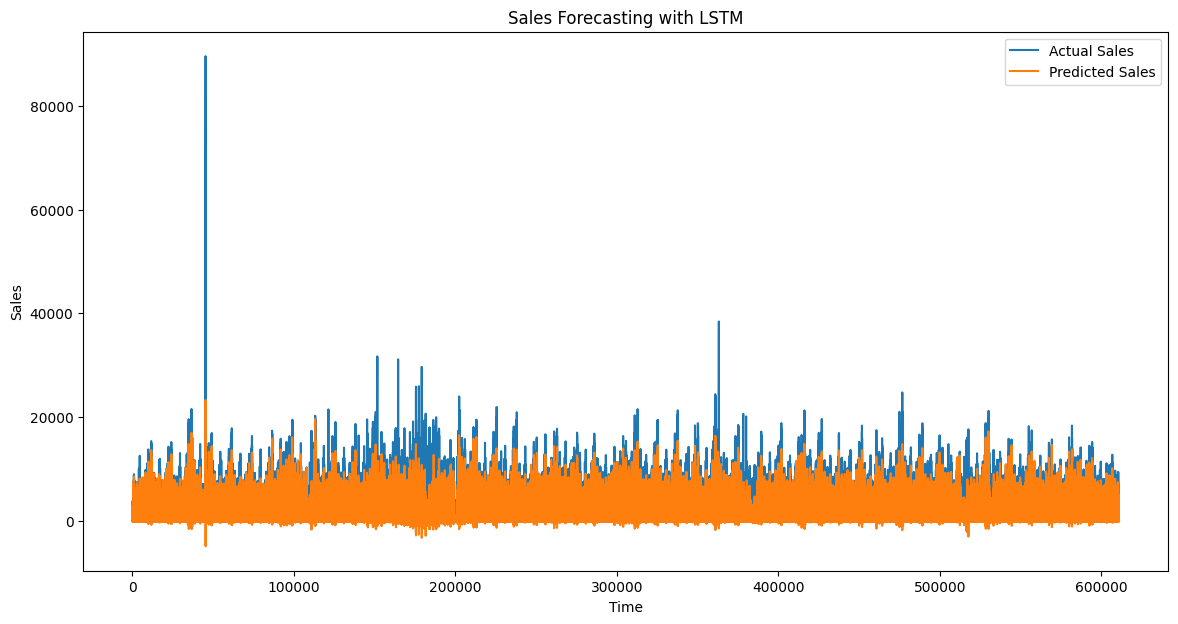

In [63]:
# Plot actual vs predicted sales
plt.figure(figsize=(14, 7))
plt.plot(sales[-len(y_test):], label='Actual Sales')
plt.plot(predicted_sales, label='Predicted Sales')
plt.title('Sales Forecasting with LSTM')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()
